# Shortcuts simulation
Some simple simulation code to show how shortcuts can arise and their effects.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

# Sampling model
We can define a sampling model, i.e., the probability of being sampled (1) or not (0) ($p(s)$), using a simple logistic regression model which depends on the dependent variable, $y$ (see [Meng, 2018](https://projecteuclid.org/euclid.aoas/1532743473)):

\begin{align}
p(s) = \mathrm{logit}^{-1}(\alpha+ y\beta)
\end{align}

Note that this does not have to depend on the dependent variable ($y$), but may also depend on (a combination of) independent variable(s) ($X$). Here, we just use it to selectively sample a part of the multivariate distribution ($[X, y]$):

In [34]:
def sample(y, α, β, n=1000):
    """ Logistic sampling model conditional on y. 
    
    Parameters
    ----------
    y : np.array
        1D numpy array to be conditioned on
    \alpha : int/float
        Intercept parameter
    \beta : int/float
        Slope parameter
    
    Returns
    -------
    idx : np.array
        Boolean array indicating whether a sample is valued (True) or not (False)
    ps : np.array
        Probability of being sampled for each observation
    """
    ps = expit(α + y * β)
    idx = np.zeros(N, dtype=bool)
    # Need to normalize probability
    selected = np.random.choice(np.arange(N), size=n, p=ps / ps.sum())
    idx[selected] = True
    return idx, ps

Before we show how selective (non-random) sampling can mess up conditional models (predicting $y$ given $X$), let's see how it messes up marginal models (i.e., estimating the mean of $y$). We'll simulate some random normal data with population size $N$:

In [35]:
N = 10000
y = np.random.normal(0, 1, size=N)

By varying the $\beta$ parameter from our logistic sampling model, we'll sample more or less uniformly from $y$ (higher $\beta$ means higher probability of sampling high $y$ values). This shows that the less uniformly we sample, the higher the discrepancy between the true mean and the estimated mean ($\hat{\mu}$):

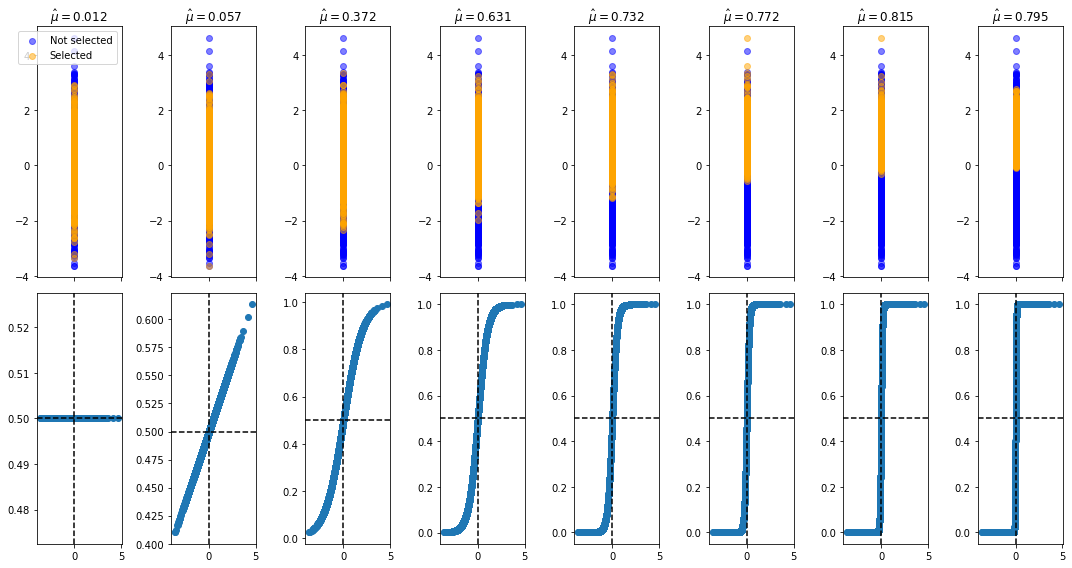

In [36]:
fig, axes = plt.subplots(ncols=8, nrows=2, figsize=(15, 8), sharex=True, sharey=False)
for i, β in enumerate([0, 0.1, 1, 2, 4, 8, 16, 32]):
    idx, ps = sample(y, α=0, β=β)
    axes[0, i].scatter(np.zeros((~idx).sum()), y[~idx], c='blue', alpha=0.5)
    axes[0, i].scatter(np.zeros(idx.sum()), y[idx], c='orange', alpha=0.5)
    muhat = y[idx].mean()
    axes[0, i].set_title(r'$\hat{\mu} = $' + f'{muhat:.3f}')
    axes[1, i].scatter(y, ps)
    axes[1, i].axhline(0.5, ls='--', c='k')
    axes[1, i].axvline(0, ls='--', c='k')
    
    if i == 0:
        axes[0, 0].legend(['Not selected', 'Selected'])

plt.tight_layout()

This is rather trivial. But what happens if we look at prediction in a conditional model, i.e., we want to predict $y$ from $X$ (assuming the true generative model is as such)? We'll use the same sampling model and evaluate cross-validated R-squared values.

## Simple model
Let's start with a simple linear model.

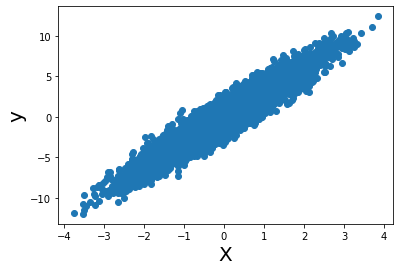

In [37]:
X = np.random.normal(0, 1, size=N)
β = 3
ϵ = np.random.normal(0, 1, size=N)
y = X * β + ϵ
plt.scatter(X, y)
plt.xlabel('X', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.show()

Here, we see that non-random selection does not hurt CV performance (where we cross-validate the model estimated on the selected observations to the non-selected samples):

<ipython-input-43-9b36250ebe0f>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, i].set_xticklabels(['train', 'test'], rotation=90)
<ipython-input-43-9b36250ebe0f>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, i].set_xticklabels(['train', 'test'], rotation=90)
<ipython-input-43-9b36250ebe0f>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, i].set_xticklabels(['train', 'test'], rotation=90)
<ipython-input-43-9b36250ebe0f>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, i].set_xticklabels(['train', 'test'], rotation=90)
<ipython-input-43-9b36250ebe0f>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, i].set_xticklabels(['train', 'test'], rotation=90)
<ipython-input-43-9b36250ebe0f>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, i].set_xticklabels(

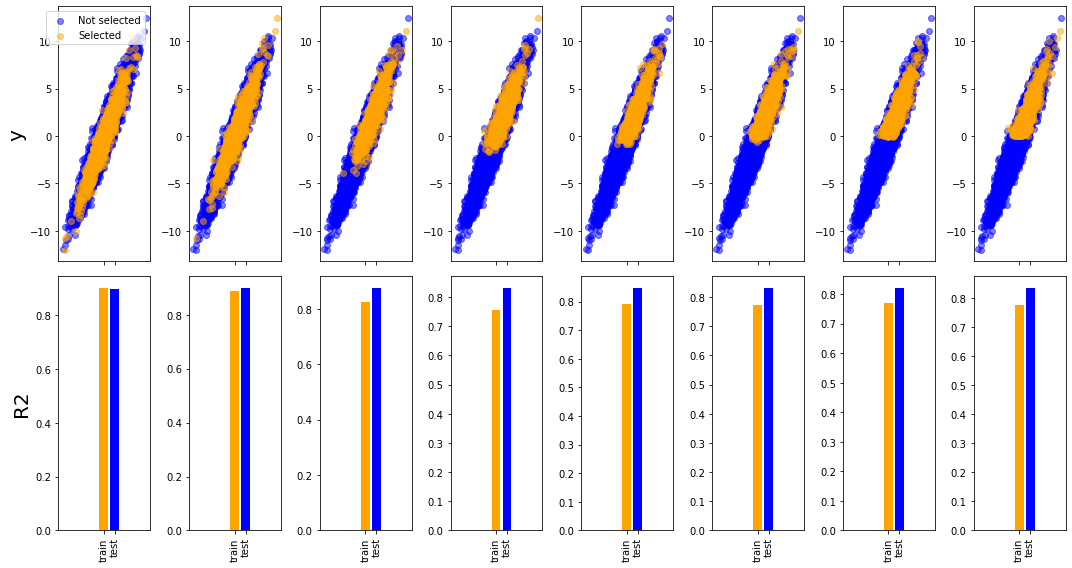

In [43]:
n = 1000
lr = LinearRegression()

fig, axes = plt.subplots(ncols=8, nrows=2, figsize=(15, 8), sharex=True, sharey=False)
for i, β in enumerate([0, 0.1, 1, 2, 4, 8, 16, 32]):
    idx, ps = sample(y, α=0, β=β)
    axes[0, i].scatter(X[~idx], y[~idx], c='blue', alpha=0.5)
    axes[0, i].scatter(X[idx], y[idx], c='orange', alpha=0.5)
    
    lr.fit(X[idx, None], y[idx])
    r2_within = lr.score(X[idx, None], y[idx])
    r2_cv = lr.score(X[~idx, None], y[~idx])
    
    axes[1, i].bar(['train', 'test'], [r2_within, r2_cv], color=['orange', 'blue'])
    axes[1, i].set_xticklabels(['train', 'test'], rotation=90)

    if i == 0:
        axes[0, 0].legend(['Not selected', 'Selected'])
        axes[0, 0].set_ylabel('y', fontsize=20)
        axes[1, 0].set_ylabel('R2', fontsize=20)

plt.tight_layout()

## Interaction model
Generalization becomes worse, however, when the same model does not apply everywhere, like in an interaction model:

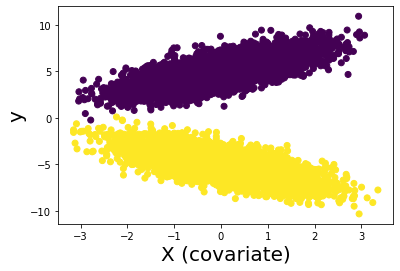

In [45]:
X1a = np.repeat([0, 1], repeats=N // 2)  # e.g., men
X1b = np.ones(N) - X1a  # e.g., women
X2 = np.random.normal(0, 1, size=N)  # some covariate
X = np.c_[X1a, X1b, X2, X1a * X2, X1b * X2]
β = np.array([-5, 5, 0, -1, 1])
ϵ = np.random.normal(0, 1, size=N)
y = X @ β + ϵ
plt.scatter(X2, y, c=X1a)
plt.xlabel("X (covariate)", fontsize=20)
plt.ylabel('y', fontsize=20)
plt.show()

<ipython-input-47-d7982f573870>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, i].set_xticklabels(['train', 'test'], rotation=90)
<ipython-input-47-d7982f573870>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, i].set_xticklabels(['train', 'test'], rotation=90)
<ipython-input-47-d7982f573870>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, i].set_xticklabels(['train', 'test'], rotation=90)
<ipython-input-47-d7982f573870>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, i].set_xticklabels(['train', 'test'], rotation=90)
<ipython-input-47-d7982f573870>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, i].set_xticklabels(['train', 'test'], rotation=90)
<ipython-input-47-d7982f573870>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, i].set_xticklabels(

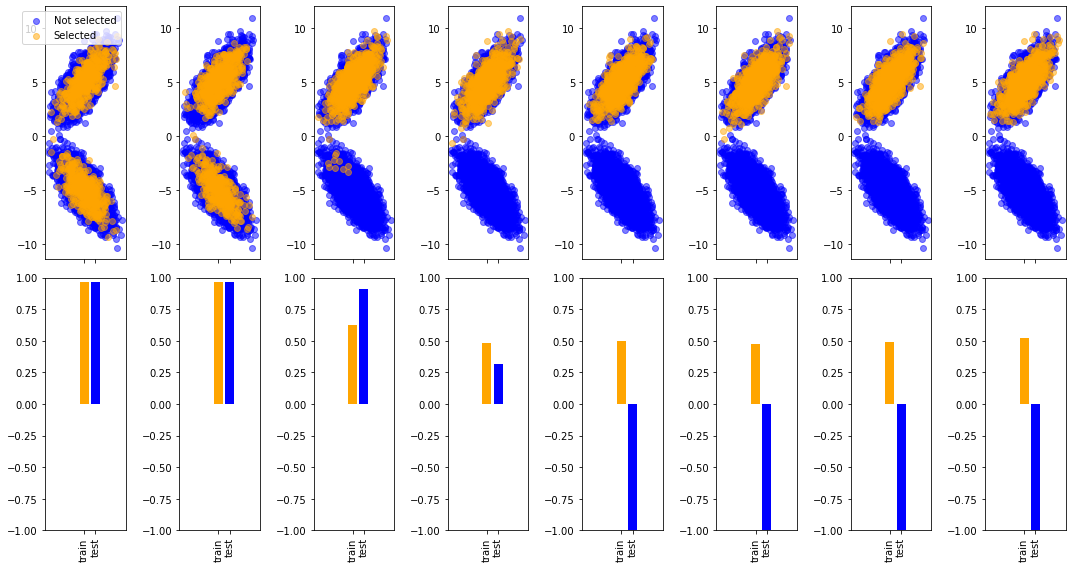

In [47]:
n = 1000
lr = LinearRegression()

fig, axes = plt.subplots(ncols=8, nrows=2, figsize=(15, 8), sharex=True, sharey=False)
for i, β in enumerate([0, 0.1, 1, 2, 4, 8, 16, 32]):
    idx, ps = sample(y, α=0, β=β)
    axes[0, i].scatter(X[~idx, 2], y[~idx], c='blue', alpha=0.5)
    axes[0, i].scatter(X[idx, 2], y[idx], c='orange', alpha=0.5)
    
    lr.fit(X[idx], y[idx])
    r2_within = lr.score(X[idx], y[idx])
    r2_cv = lr.score(X[~idx], y[~idx])
    
    axes[1, i].bar(['train', 'test'], [r2_within, r2_cv], color=['orange', 'blue'])
    axes[1, i].set_xticklabels(['train', 'test'], rotation=90)
    axes[1, i].set_ylim(-1, 1)
    if i == 0:
        axes[0, 0].legend(['Not selected', 'Selected'])

plt.tight_layout()